In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from brokenaxes import brokenaxes

mpl.rcParams['font.size'] = 8

In [2]:
from scipy.signal import savgol_filter, find_peaks

In [3]:
def pseudo_voigt(x, mu, gamma_gaussian, gamma_lorentzian, amplitude, eta):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    a_G = (2 / gamma_gaussian) * np.sqrt(np.log(2) / np.pi)
    b_G = (4 * np.log(2)) / (gamma_gaussian**2)
    gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
    
    lorentzian_term = (1 / np.pi) * ( (gamma_lorentzian / 2) / ( (x - mu)**2 + (gamma_lorentzian / 2)**2) ) 
    
    result = amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    return result

In [4]:
x_values = np.linspace(0, 100, 1000)
y_values = (
            np.exp(-(x_values - 20)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 25)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 30)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 50)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 75)**2 / (2 * 3**2)) +
            np.exp(-(x_values - 80)**2 / (2 * 2**2)) + 
            np.random.normal(0, 0.001, x_values.size)
            )

In [5]:
df = pd.read_csv("~/data/dataset.csv")
wn = pd.read_csv("~/data/domain.csv").to_numpy().reshape(-1)
X = df.drop(columns=['HbA1c', 'years'])
X.columns = wn


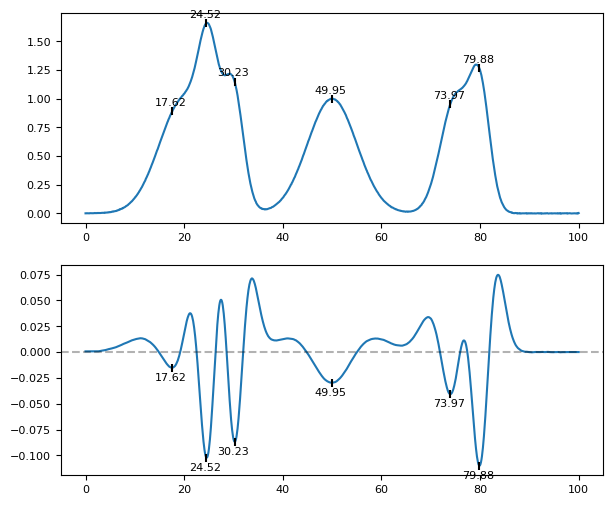

,Index,Value
0,176,17
1,245,24
2,302,30
3,499,49
4,739,73
5,798,79


In [6]:
def peaks_second_deriv(x_values, 
                       y_values, 
                       window_length=10,
                       polyorder=2,
                       **kwargs):
    
    first_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=1)
    second_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=2)
    second_deriv = second_deriv / np.linalg.norm(second_deriv)
    peaks = find_peaks(-second_deriv, **kwargs)[0]

    fig, axs = plt.subplots(2, 1, figsize=(7, 6))
    axs[0].plot(x_values, y_values)
    axs[0].scatter(x_values[peaks], y_values[peaks], color='k', marker='|', linewidth=1.5, zorder=5)

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[0].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, y_values[peak]), 
                        xytext=(peak_pos - 3.5, y_values[peak] + 0.1 * y_values.mean()),
                        fontsize=8
                        )

    axs[1].plot(x_values, second_deriv)
    axs[1].scatter(x_values[peaks], second_deriv[peaks], color='k', marker='|', linewidth=1.5, zorder=5)
    axs[1].axhline(y=0, linestyle="--", alpha=0.3, color='k')

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[1].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, second_deriv[peak]), 
                        xytext=(peak_pos - 3.5, second_deriv[peak] - 0.6 * np.abs(second_deriv).mean()),
                        fontsize=8
                        )
        
    peak_results = pd.DataFrame({
        "Index": peaks,
        "Value": [int(x_values[peak]) for peak in peaks]
    })

    plt.show()

    return peak_results

peaks_second_deriv(x_values, 
                   y_values, 
                   window_length=50, 
                   height=0.001, 
                   prominence=0.0001, 
                   distance=20)

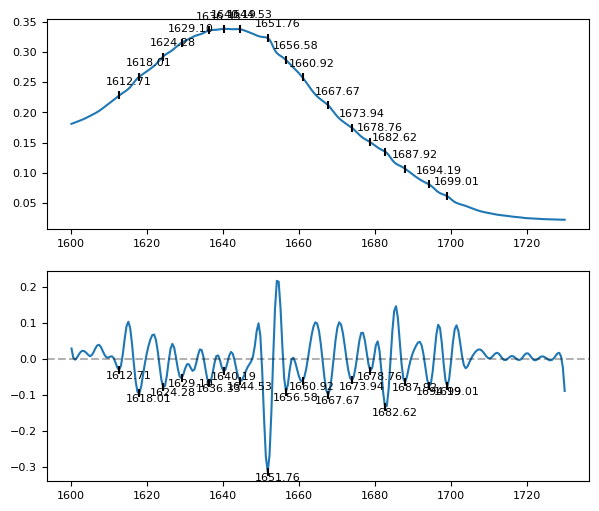

In [7]:
sample = X.mean()
sample = sample[(sample.index >= 1600) & (sample.index <= 1730)]

res = peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=21,
                   polyorder=7,
                   height=0.03, 
                   prominence=0.00001, 
                   distance=7)

In [8]:
res['Value'].to_csv("~/data/peaks_amide1.csv", index=None)

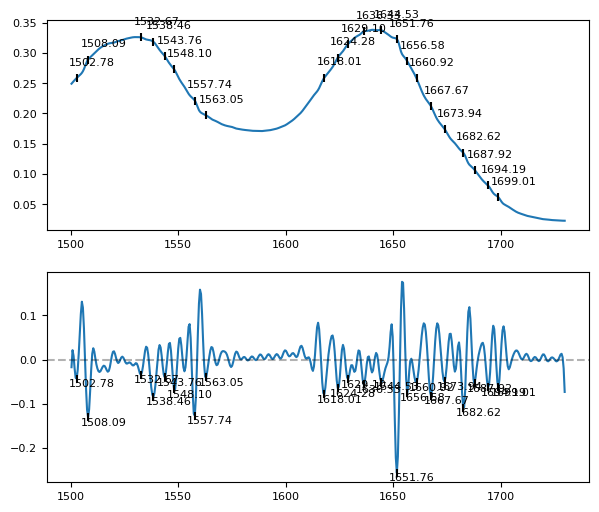

In [22]:
sample = X.mean()
sample = sample[(sample.index >= 1500) & (sample.index <= 1730)]

res_1500_1700 = peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=21,
                   polyorder=7,
                   height=0.03, 
                   prominence=0.00001, 
                   distance=7)

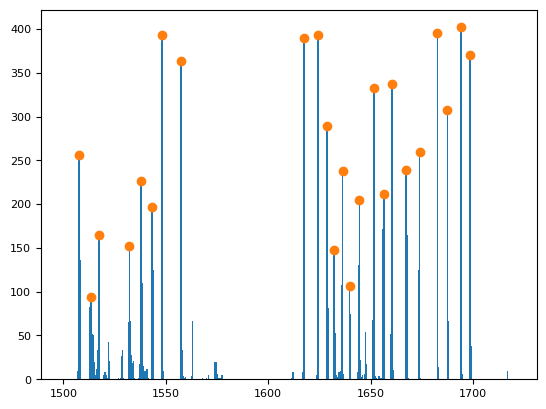

In [10]:
def find_peaks_matrix(domain,
                      absorbance,
                      window_length=10,
                      polyorder=2,
                      threshold=0.5,
                      **kwargs):
    
    n_samples, n_features = absorbance.shape
    
    X_deriv = absorbance.T.apply(lambda col: savgol_filter(col, 
                                                           window_length=window_length, 
                                                           polyorder=polyorder, 
                                                           deriv=2)).T
    X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)

    total_peaks = np.zeros(n_features)


    for index, row in X_deriv.iterrows():
        peaks = find_peaks(-row, **kwargs)[0]
        total_peaks[peaks] += 1


    peaks_counts, *_ = find_peaks(total_peaks, height=int(n_samples * threshold))
    plt.bar(domain, total_peaks)
    plt.scatter(domain[peaks_counts], total_peaks[peaks_counts])
    # plt.xlim([1600, 1730])
    plt.show()

    # print(peaks_counts.shape)
    # absorbance.T.plot(legend=False)
    # plt.scatter(domain[peaks_counts], absorbance.mean().to_numpy()[peaks_counts])

    return domain[peaks_counts]

X_amide1 = X.iloc[:, (X.columns >= 1500) & (X.columns <= 1720)]

peaks_amides = find_peaks_matrix(X_amide1.columns.to_numpy(), 
                   X_amide1, 
                   window_length=10, 
                   height=0.03, 
                   prominence=0.0001, 
                   distance=7,
                   threshold=0.2)

<Axes: >

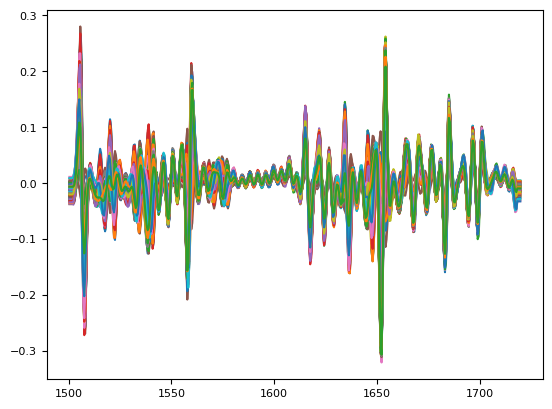

In [11]:
X_deriv = X_amide1.T.apply(lambda col: savgol_filter(col, window_length=7, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)

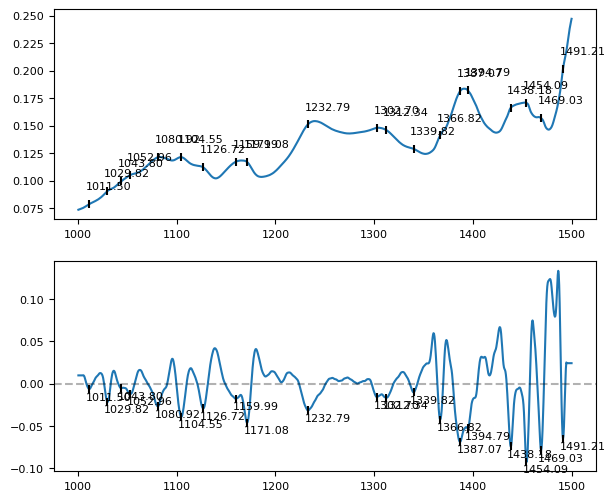

In [12]:
sample = X.mean()
sample = sample[(sample.index >= 1000) & (sample.index <= 1500)]

res_1000_1500 = peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=20, 
                   polyorder=2,
                   height=0.001, 
                   prominence=0.00001, 
                   distance=10)

In [13]:
res_1000_1500

,Index,Value
0,23,1011
1,61,1029
2,90,1043
3,109,1052
4,167,1080
5,216,1104
6,262,1126
7,331,1159
8,354,1171
9,482,1232


In [23]:
res_1500_1700

,Index,Value
0,5,1502
1,16,1508
2,67,1532
3,79,1538
4,90,1543
5,99,1548
6,119,1557
7,130,1563
8,244,1618
9,257,1624


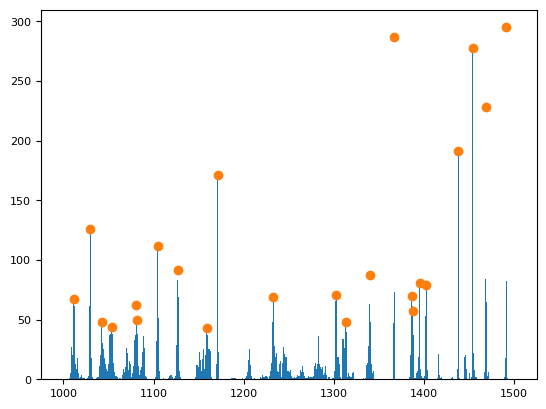

In [14]:
X_1000_1500 = X.iloc[:, (X.columns >= 1000) & (X.columns <= 1500)]

peaks_1000_1500 = find_peaks_matrix(X_1000_1500.columns.to_numpy(), 
                X_1000_1500, 
                window_length=20,
                polyorder=2,
                height=0.001, 
                prominence=0.00001, 
                distance=15,
                threshold=0.1
                )

<Axes: >

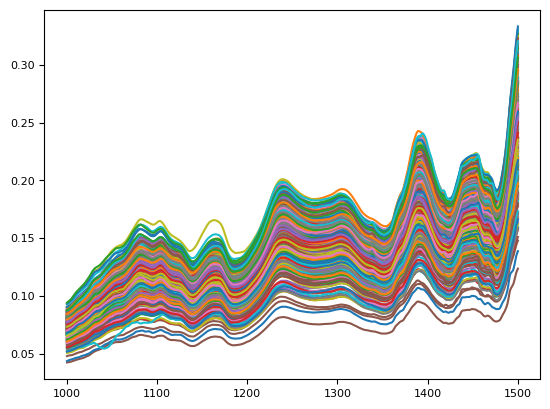

In [15]:
X_1000_1500.T.plot(legend=False)

In [16]:
len(peaks_amides)

24

In [17]:
len(peaks_1000_1500)

23

length:  47


array([1011.497, 1029.818, 1042.353, 1053.442, 1080.441, 1081.406,
       1105.03 , 1127.207, 1159.028, 1171.081, 1232.793, 1302.701,
       1313.307, 1340.306, 1366.823, 1386.59 , 1388.037, 1395.269,
       1402.5  , 1438.178, 1454.088, 1469.034, 1491.211, 1507.604,
       1513.389, 1517.246, 1532.192, 1537.978, 1543.281, 1548.102,
       1557.262, 1617.528, 1624.278, 1628.617, 1631.992, 1636.331,
       1639.706, 1644.527, 1651.759, 1656.58 , 1660.437, 1667.187,
       1673.937, 1682.615, 1687.436, 1694.186, 1698.525])

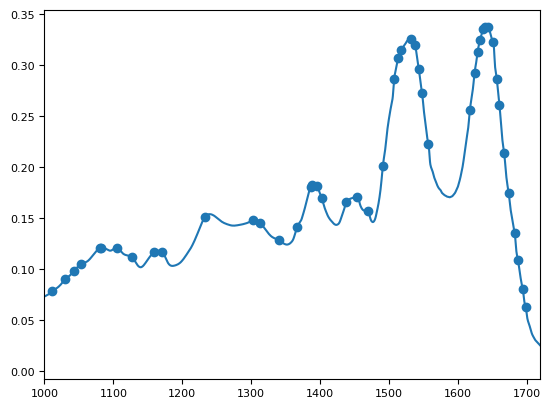

In [18]:
x_values = X.columns.to_numpy()
y_values = X.mean().to_numpy()

peaks = np.concatenate([peaks_1000_1500, peaks_amides])
peaks_idx = [np.argmin(np.abs(x_values - peak)) for peak in peaks]
print("length: ", len(peaks))


plt.plot(x_values, y_values)
plt.scatter(x_values[peaks_idx], y_values[peaks_idx])
plt.xlim([1000, 1720])

# pd.Series(peaks).to_csv(f'~/data/peaks_{int(len(peaks))}.csv', index=False)
peaks

In [19]:
# wavenumber_mask = ((X.columns >= 1000) & (X.columns <= 3700)) & ~((X.columns > 1800) & (X.columns < 2700))
# X = X.iloc[:, wavenumber_mask]
# X.head(10)

In [20]:
# fig = plt.figure(figsize=(8, 2))
# bax = brokenaxes(xlims=((1000, 1800), (2700, 3700)))

# wn = X.columns
# absorbance = X.mean()

# bax.plot(wn, absorbance)
# # bax.legend(loc=3)
# bax.set_xlabel('Wavenumber')
# bax.set_ylabel('Absorbance')

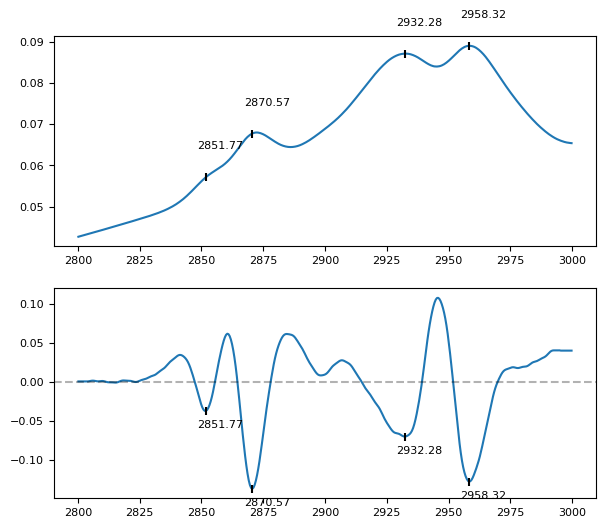

,Index,Value
0,107,2851
1,146,2870
2,274,2932
3,328,2958


In [21]:
sample = X.mean()
sample = sample[(sample.index >= 2800) & (sample.index <= 3000)]

peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=18, 
                   polyorder=2,
                   height=0.001, 
                   prominence=0.00001, 
                   distance=10)

In [29]:
pd.Series(np.concatenate([res_1000_1500['Value'], res_1500_1700['Value']])).to_csv("~/data/peaks_42_m.csv", index=None)